In [5]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import time
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        state, action, reward, next_state, done = map(np.stack, zip(*[self.buffer[i] for i in batch]))
        return (
            torch.FloatTensor(state).to(device),
            torch.FloatTensor(action).to(device),
            torch.FloatTensor(reward).unsqueeze(1).to(device),
            torch.FloatTensor(next_state).to(device),
            torch.FloatTensor(done).unsqueeze(1).to(device)
        )
        
    def __len__(self):
        return len(self.buffer)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super(Actor, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)
        
        self.max_action = max_action
        self.action_dim = action_dim
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0.0)
            
    def forward(self, state):
        x = self.net(state)
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        return mean, log_std
    
    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        
        x_t = normal.rsample()
        
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        
        log_prob = normal.log_prob(x_t)
        
        log_prob -= torch.log(self.max_action * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        
        return action, log_prob
    
    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        if evaluate:
            with torch.no_grad():
                mean, _ = self.forward(state)
                return torch.tanh(mean).cpu().data.numpy().flatten() * self.max_action
        else:
            with torch.no_grad():
                action, _ = self.sample(state)
                return action.cpu().data.numpy().flatten()

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        
        self.q1_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.q2_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.constant_(m.bias, 0.0)
            
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        q1 = self.q1_net(x)
        q2 = self.q2_net(x)
        
        return q1, q2
    
    def q1(self, state, action):
        x = torch.cat([state, action], 1)
        return self.q1_net(x)

class SAC:
    def __init__(
        self, 
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_freq=2,
        lr=3e-4,
        alpha=0.2,
        automatic_entropy_tuning=True,
        hidden_dim=256,
        batch_size=256,
        buffer_size=1_000_000
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_freq = policy_freq
        self.alpha = alpha
        self.automatic_entropy_tuning = automatic_entropy_tuning
        self.batch_size = batch_size
        
        self.actor = Actor(state_dim, action_dim, max_action, hidden_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
            
        if self.automatic_entropy_tuning:
            self.target_entropy = -torch.prod(torch.Tensor([action_dim]).to(device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)
            
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        self.total_iterations = 0
        self.critic_loss_history = []
        self.actor_loss_history = []
        self.entropy_loss_history = [] if self.automatic_entropy_tuning else None
        
    def select_action(self, state, evaluate=False):
        return self.actor.select_action(state, evaluate)
    
    def update_parameters(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
        
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            next_q1, next_q2 = self.critic_target(next_state, next_action)
            next_q = torch.min(next_q1, next_q2)
            target_q = reward + (1 - done) * self.discount * (next_q - self.alpha * next_log_prob)
        
        current_q1, current_q2 = self.critic(state, action)
        
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        if self.total_iterations % self.policy_freq == 0:
            sampled_actions, log_probs = self.actor.sample(state)
            q1, q2 = self.critic(state, sampled_actions)
            q = torch.min(q1, q2)
            
            actor_loss = (self.alpha * log_probs - q).mean()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            if self.automatic_entropy_tuning:
                alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
                self.alpha_optimizer.zero_grad()
                alpha_loss.backward()
                self.alpha_optimizer.step()
                self.alpha = self.log_alpha.exp()
            
            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
        
        self.total_iterations += 1
    
    def save(self, filename):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'critic_target': self.critic_target.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_optimizer': self.critic_optimizer.state_dict(),
            'log_alpha': self.log_alpha if self.automatic_entropy_tuning else None,
            'alpha_optimizer': self.alpha_optimizer.state_dict() if self.automatic_entropy_tuning else None
        }, filename)
        
    def load(self, filename):
        checkpoint = torch.load(filename)
        
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.critic_target.load_state_dict(checkpoint['critic_target'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
        
        if self.automatic_entropy_tuning:
            self.log_alpha = checkpoint['log_alpha']
            self.alpha_optimizer.load_state_dict(checkpoint['alpha_optimizer'])
            self.alpha = self.log_alpha.exp()

def train_sac(env_id, max_timesteps=1_000_000, eval_freq=5000, seed=0):
    env = gym.make(env_id)
    eval_env = gym.make(env_id)
    
    env.action_space.seed(seed)
    eval_env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    sac = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        discount=0.99,
        tau=0.005,
        policy_freq=1,
        lr=3e-4,
        alpha=0.2,
        automatic_entropy_tuning=True,
        hidden_dim=256,
        batch_size=256,
        buffer_size=1_000_000
    )
    
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    episode_rewards = []
    avg_rewards = []
    timesteps_list = []
    best_avg_reward = -float('inf')
    
    training_metrics = {
        'timesteps': [],
        'episode_rewards': [],
        'avg_rewards': [],
        'critic_losses': [],
        'actor_losses': [],
        'entropy_losses': [] if sac.automatic_entropy_tuning else None
    }
    
    eval_rewards = []
    eval_timesteps = []
    
    state, _ = env.reset(seed=seed)
    done = False
    
    recent_rewards = deque(maxlen=100)
    
    for t in range(max_timesteps):
        episode_timesteps += 1
        
        if t < 10000:
            action = env.action_space.sample()
        else:
            action = sac.select_action(state)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        sac.replay_buffer.push(state, action, reward, next_state, float(done))
        
        sac.update_parameters()
        
        state = next_state
        episode_reward += reward
        
        if done:
            recent_rewards.append(episode_reward)
            episode_rewards.append(episode_reward)
            avg_reward = np.mean(list(recent_rewards))
            avg_rewards.append(avg_reward)
            timesteps_list.append(t + 1)
            
            training_metrics['timesteps'].append(t + 1)
            training_metrics['episode_rewards'].append(episode_reward)
            training_metrics['avg_rewards'].append(avg_reward)
            
            if len(sac.critic_loss_history) > 0:
                training_metrics['critic_losses'].append(np.mean(sac.critic_loss_history[-episode_timesteps:]))
            
            if len(sac.actor_loss_history) > 0:
                training_metrics['actor_losses'].append(np.mean(sac.actor_loss_history[-episode_timesteps//sac.policy_freq:]))
            
            if sac.automatic_entropy_tuning and len(sac.entropy_loss_history) > 0:
                training_metrics['entropy_losses'].append(np.mean(sac.entropy_loss_history[-episode_timesteps//sac.policy_freq:]))
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                sac.save(f"sac_{env_id}_best.pt")
            
            state, _ = env.reset()
            done = False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
        
        if (t + 1) % eval_freq == 0:
            eval_reward = evaluate_policy(sac, eval_env, seed=seed)
            eval_rewards.append(eval_reward)
            eval_timesteps.append(t + 1)
            print(f"Evaluation at timestep {t+1}: Average Reward = {eval_reward:.2f}")
    
    sac.save(f"sac_{env_id}_final.pt")
    
    plot_training_curves(
        timesteps_list, 
        episode_rewards, 
        avg_rewards, 
        eval_timesteps, 
        eval_rewards,
        training_metrics,
        env_id
    )
    
    return sac

def evaluate_policy(policy, env, eval_episodes=10, seed=0):
    avg_reward = 0.
    
    for _ in range(eval_episodes):
        state, _ = env.reset(seed=seed)
        done = False
        while not done:
            action = policy.select_action(state, evaluate=True)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            avg_reward += reward
    
    avg_reward /= eval_episodes
    
    return avg_reward

def plot_training_curves(timesteps, rewards, avg_rewards, eval_timesteps, eval_rewards, training_metrics, env_id):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(timesteps, rewards, alpha=0.3, label='Episode Rewards')
    plt.plot(timesteps, avg_rewards, label='Average Rewards (100 episodes)')
    if len(eval_timesteps) > 0:
        plt.plot(eval_timesteps, eval_rewards, 'r--', label='Evaluation Rewards')
    plt.xlabel('Timesteps')
    plt.ylabel('Reward')
    plt.title(f'Learning Curve for SAC on {env_id}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    if len(training_metrics['critic_losses']) > 0:
        plt.plot(training_metrics['timesteps'], training_metrics['critic_losses'], label='Critic Loss')
        plt.xlabel('Timesteps')
        plt.ylabel('Loss')
        plt.title('Critic Loss')
        plt.grid(True)
    
    plt.subplot(2, 2, 3)
    if len(training_metrics['actor_losses']) > 0:
        plt.plot(training_metrics['timesteps'], training_metrics['actor_losses'], label='Actor Loss')
        plt.xlabel('Timesteps')
        plt.ylabel('Loss')
        plt.title('Actor Loss')
        plt.grid(True)
    
    plt.subplot(2, 2, 4)
    if training_metrics['entropy_losses'] is not None and len(training_metrics['entropy_losses']) > 0:
        plt.plot(training_metrics['timesteps'], training_metrics['entropy_losses'], label='Entropy Loss')
        plt.xlabel('Timesteps')
        plt.ylabel('Loss')
        plt.title('Entropy Loss')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'sac_{env_id}_training_curves.png')
    plt.show()

def render_policy(policy, env_id, episodes=1):
    try:
        env = gym.make(env_id, render_mode="rgb_array")
        
        for ep in range(episodes):
            state, _ = env.reset()
            done = False
            ep_reward = 0
            
            frames = []
            
            while not done:
                frame = env.render()
                if frame is not None:
                    frames.append(frame)
                
                action = policy.select_action(state, evaluate=True)
                
                state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                ep_reward += reward
            
            print(f"Rendered episode {ep+1}: Reward = {ep_reward:.2f}")
            
            if len(frames) > 0:
                try:
                    import imageio
                    imageio.mimsave(f'sac_{env_id}_episode_{ep+1}.mp4', frames, fps=30)
                    print(f"Video saved as sac_{env_id}_episode_{ep+1}.mp4")
                except ImportError:
                    print("Could not save video: imageio not installed.")
    
    except Exception as e:
        print(f"Error during rendering: {e}")
    
    finally:
        env.close()

Using device: mps


Training SAC on Hopper-v4...
Episode 1: Reward = 19.46, Avg Reward = 19.46, Total Timesteps = 26
Episode 2: Reward = 110.80, Avg Reward = 65.13, Total Timesteps = 99
Episode 3: Reward = 21.48, Avg Reward = 50.58, Total Timesteps = 123
Episode 4: Reward = 37.24, Avg Reward = 47.25, Total Timesteps = 166
Episode 5: Reward = 22.08, Avg Reward = 42.21, Total Timesteps = 195
Episode 6: Reward = 10.11, Avg Reward = 36.86, Total Timesteps = 207
Episode 7: Reward = 19.61, Avg Reward = 34.40, Total Timesteps = 250
Episode 8: Reward = 11.39, Avg Reward = 31.52, Total Timesteps = 265
Episode 9: Reward = 16.53, Avg Reward = 29.86, Total Timesteps = 283
Episode 10: Reward = 30.98, Avg Reward = 29.97, Total Timesteps = 314
Episode 11: Reward = 12.31, Avg Reward = 28.36, Total Timesteps = 327
Episode 12: Reward = 8.13, Avg Reward = 26.68, Total Timesteps = 338
Episode 13: Reward = 8.80, Avg Reward = 25.30, Total Timesteps = 362
Episode 14: Reward = 9.91, Avg Reward = 24.20, Total Timesteps = 384
Epis

ValueError: x and y must have same first dimension, but have shapes (1548,) and (1541,)

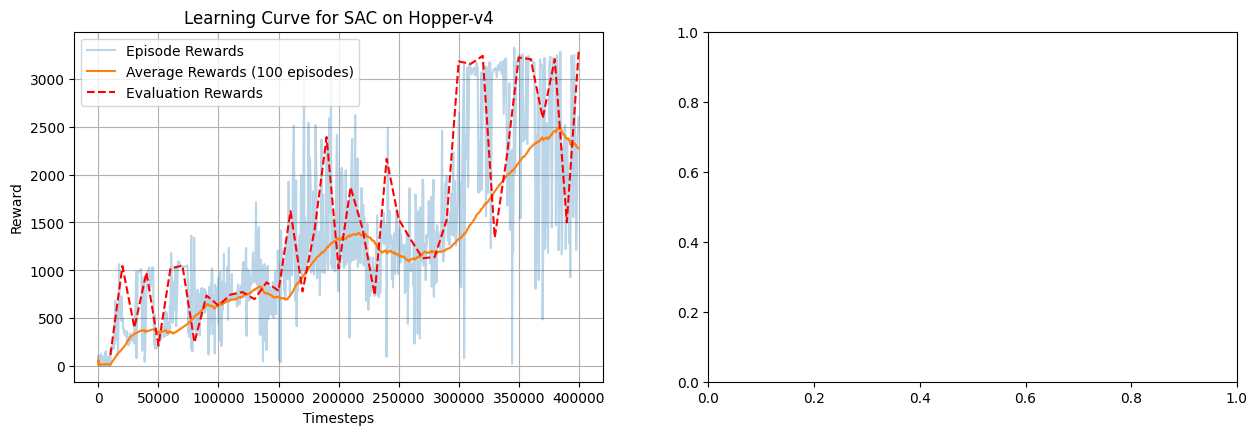

In [6]:
env_id = "Hopper-v4"
print(f"Training SAC on {env_id}...")

start_time = time.time()
sac = train_sac(env_id, max_timesteps=4_00_000, eval_freq=10000)
end_time = time.time()

training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds.")

eval_env = gym.make(env_id)
final_reward = evaluate_policy(sac, eval_env, eval_episodes=10)
print(f"Final evaluation: Average Reward = {final_reward:.2f}")

if hasattr(eval_env, 'render') and callable(eval_env.render):
    render_policy(sac, env_id)